<a href="https://colab.research.google.com/github/Koushik890/LipSyncNet/blob/main/LipSyncNet_3DCNN_EfficientNetB0_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install and Import Dependencies

In [ ]:
!pip list

Package                      Version
---------------------------- ---------------
absl-py                      2.1.0
anyio                        4.3.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.14.0
beautifulsoup4               4.12.3
bleach                       6.1.0
cachetools                   5.3.2
certifi                      2024.2.2
cffi                         1.16.0
charset-normalizer           3.3.2
click                        8.1.7
comm                         0.2.1
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
defusedxml                   0.7.1
exceptiongroup               1.2.0
executing                    2.0.1
fastjsonschema               2.19

In [ ]:
!pip install opencv-python matplotlib imageio gdown

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
from tensorflow.keras.optimizers import Adam

2024-02-24 20:27:37.714545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-24 20:27:37.819205: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-24 20:27:37.823153: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/guest/my_project_dir/my_project_env/lib/python3.10/site-packages/cv2/../../lib

In [ ]:
tf.config.list_physical_devices('GPU')

2024-02-24 20:27:38.832511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-24 20:27:38.832840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-24 20:27:38.833118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-24 20:27:38.833403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-24 20:27:38.833676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

[]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=6cef9731-d0a8-4cf8-8a69-4c605214b143
To: /home/guest/my_project_dir/my_project_env/LipNet_master_3DCNN_BiLSTTM_full_4/data.zip
100%|█████████████████████████████████████████████████████████████████████████████████| 423M/423M [00:04<00:00, 101MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [ ]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


2024-02-24 20:27:45.420495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    # Use os.path for cross-platform compatibility
    file_name = os.path.splitext(os.path.basename(path))[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
test_path = 'bbal6n.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

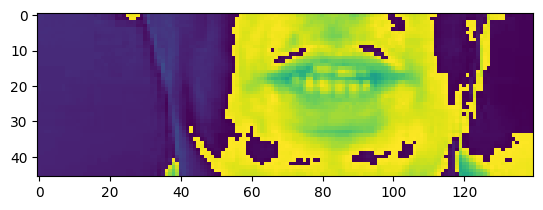

In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [ ]:
len(test)

50

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames)

2

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next(); val[0]

array([[[[[ 1.4715209 ],
          [ 1.4715209 ],
          [ 1.3919792 ],
          ...,
          [ 9.50523   ],
          [10.062021  ],
          [10.062021  ]],

         [[ 1.4715209 ],
          [ 1.4715209 ],
          [ 1.3919792 ],
          ...,
          [ 9.465459  ],
          [ 0.        ],
          [ 9.98248   ]],

         [[ 1.3522085 ],
          [ 1.3522085 ],
          [ 1.3522085 ],
          ...,
          [ 9.98248   ],
          [ 0.11931251],
          [ 0.11931251]],

         ...,

         [[ 0.9942709 ],
          [ 0.9942709 ],
          [ 0.9545001 ],
          ...,
          [10.141563  ],
          [10.101792  ],
          [10.101792  ]],

         [[ 0.9942709 ],
          [ 0.9942709 ],
          [ 0.9545001 ],
          ...,
          [10.062021  ],
          [10.022251  ],
          [10.022251  ]],

         [[ 0.9942709 ],
          [ 0.9942709 ],
          [ 0.9545001 ],
          ...,
          [10.062021  ],
          [10.022251  ],
          

In [ ]:
# Assuming `val[0][0]` is your image data
image_data = val[0][0]

# Normalize your data to be between 0 and 255
normalized_data = np.clip(image_data, 0, 255)

# Convert to uint8
uint8_data = normalized_data.astype(np.uint8)

# Remove the last dimension since it's grayscale
squeezed_data = uint8_data.squeeze(-1)

# Calculate duration based on fps
duration = 1000 / 10  # for fps=10

# Save the image sequence as a GIF
imageio.mimsave('./animation.gif', squeezed_data, duration=duration)

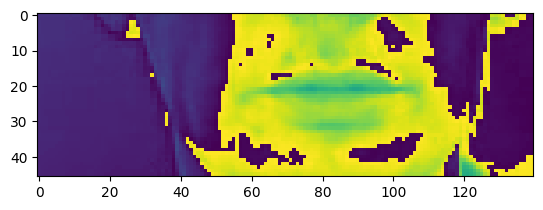

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay green with g two now'>

# 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, Flatten, Dense, TimeDistributed, Dropout, Bidirectional, LSTM, concatenate, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
input_shape = (75, 46, 140, 1)  # Original input shape

# Input layer
input_layer = Input(shape=input_shape)

# 3D Convolutional layers with BatchNormalization
conv3d_1 = Conv3D(64, (3, 3, 3), padding='same', activation='relu')(input_layer)
bn1 = BatchNormalization()(conv3d_1)
maxpool3d_1 = MaxPool3D((1,2,2))(bn1)

conv3d_2 = Conv3D(128, (3, 3, 3), padding='same', activation='relu')(maxpool3d_1)
bn2 = BatchNormalization()(conv3d_2)
maxpool3d_2 = MaxPool3D((1,2,2))(bn2)

conv3d_3 = Conv3D(256, (3, 3, 3), padding='same', activation='relu')(maxpool3d_2)
bn3 = BatchNormalization()(conv3d_3)
maxpool3d_3 = MaxPool3D((1,2,2))(bn3)

conv3d_4 = Conv3D(512, (3, 3, 3), padding='same', activation='relu')(maxpool3d_3)
bn4 = BatchNormalization()(conv3d_4)
maxpool3d_4 = MaxPool3D((1,2,2))(bn4)

# Flatten the output of the 3D conv layers
flattened_3d_conv_output = TimeDistributed(Flatten())(maxpool3d_4)

# Prepare input for EfficientNetB0
efficientnet_input_adjusted = Lambda(lambda x: tf.repeat(x, 3, -1))(input_layer)
efficientnet_input_adjusted = TimeDistributed(Lambda(lambda x: tf.image.resize(x, (224, 224))))(efficientnet_input_adjusted)

# EfficientNetB0 feature extraction
efficientnet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# Fine-tuning: Unfreeze the top 20 layers
efficientnet.trainable = True
for layer in efficientnet.layers[:-20]:
    layer.trainable = False

efficientnet_features = TimeDistributed(efficientnet)(efficientnet_input_adjusted)
flattened_efficientnet_output = TimeDistributed(Flatten())(efficientnet_features)

# Concatenate the features from 3D Conv and EfficientNetB0
concatenated_features = concatenate([flattened_3d_conv_output, flattened_efficientnet_output])

# BiLSTM layers
bilstm_1 = Bidirectional(LSTM(512, return_sequences=True))(concatenated_features)  # Increased units
dropout_1 = Dropout(0.3)(bilstm_1)  # Adjusted dropout rate
bilstm_2 = Bidirectional(LSTM(512, return_sequences=True))(dropout_1)  # Increased units, ensure return_sequences=True
dropout_2 = Dropout(0.3)(bilstm_2)  # Adjusted dropout rate

# Output layer: Assuming `num_classes` is defined based on your dataset
output_layer = TimeDistributed(Dense(char_to_num.vocabulary_size()+1, activation='softmax'))(dropout_2)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Model summary to inspect the final output shape
# Model summary to inspect the final output shape
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 46, 140  0           []                               
                                , 1)]                                                             
                                                                                                  
 conv3d (Conv3D)                (None, 75, 46, 140,  1792        ['input_1[0][0]']                
                                 64)                                                              
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 46, 140,  256        ['conv3d[0][0]']                 
 alization)                      64)                                                          

In [ ]:
5*17*75

6375

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 3s 3s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'6666666666666666666666666666666666666666666666666666666666666666666666666pp'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'6666666666666666666666666666666666666666666666666666666666666666666666666pp'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
# Compile the model with a custom CTC loss function
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.original_dataset = dataset
        self.reset_iterator()

    def reset_iterator(self):
        # Reset the iterator to the beginning of the dataset
        self.iterator = iter(self.original_dataset)

    def on_epoch_end(self, epoch, logs=None) -> None:
        try:
            data = next(self.iterator)
        except StopIteration:
            # If the iterator is exhausted, reset it and try again
            self.reset_iterator()
            data = next(self.iterator)

        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
history = model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
336/450 [=====================>........] - ETA: 5:27 - loss: 77.7943

[mpeg1video @ 0x7fd140067180] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd140067180] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 74.7773

[mpeg1video @ 0x7fbe381529c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe381529c0] Warning MVs not available
[mpeg1video @ 0x7fd758088a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd758088a40] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: place white in x zero now
Prediction: la e e e an
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white in b five again
Prediction: la e e e a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1689s 4s/step - loss: 74.7773 - val_loss: 62.9759 - lr: 1.0000e-04
Epoch 2/100
407/450 [==========================>...] - ETA: 2:13 - loss: 60.3969

[mpeg1video @ 0x7fbe8c04e2c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe8c04e2c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 60.1633

[mpeg1video @ 0x7fd554053500] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd554053500] Warning MVs not available


1/1 [==============================] - 1s 804ms/step
Original: bin red in s four please
Prediction: la re t e ean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in d five again
Prediction: la re t e ea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1656s 4s/step - loss: 60.1633 - val_loss: 55.9329 - lr: 1.0000e-04
Epoch 3/100
119/450 [======>.......................] - ETA: 16:31 - loss: 56.6788

[mpeg1video @ 0x7fd520043180] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd520043180] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 55.1903

[mpeg1video @ 0x7fd268024240] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd268024240] Warning MVs not available


1/1 [==============================] - 1s 790ms/step
Original: set green at p one soon
Prediction: la re t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red in n five soon
Prediction: la re t e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1661s 4s/step - loss: 55.1903 - val_loss: 51.1851 - lr: 1.0000e-04
Epoch 4/100
209/450 [============>.................] - ETA: 12:49 - loss: 52.1710

[mpeg1video @ 0x7fd148080bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd148080bc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 51.3854

[mpeg1video @ 0x7fbe68087fc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe68087fc0] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: lay white in y six now
Prediction: sla re it ie on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white at z two please
Prediction: sla re it ie on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1701s 4s/step - loss: 51.3854 - val_loss: 48.6296 - lr: 1.0000e-04
Epoch 5/100
211/450 [=============>................] - ETA: 13:05 - loss: 49.8116

[mpeg1video @ 0x7fbfb402c000] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbfb402c000] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 48.2306

[mpeg1video @ 0x7fd4a408c740] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd4a408c740] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: lay green by f eight now
Prediction: bla re iy ie aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red at y seven again
Prediction: bla grie iy ie aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1719s 4s/step - loss: 48.2306 - val_loss: 44.7169 - lr: 1.0000e-04
Epoch 6/100
312/450 [===================>..........] - ETA: 7:03 - loss: 44.8052

[mpeg1video @ 0x7fd3c808f800] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd3c808f800] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 44.4642

[mpeg1video @ 0x7fd25806a640] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd25806a640] Warning MVs not available


1/1 [==============================] - 1s 789ms/step
Original: bin blue in f one again
Prediction: la gre it e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue with t zero please
Prediction: la gre it oe aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1691s 4s/step - loss: 44.4642 - val_loss: 42.0644 - lr: 1.0000e-04
Epoch 7/100
387/450 [========================>.....] - ETA: 3:16 - loss: 42.6508

[mpeg1video @ 0x7fd1f403e340] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd1f403e340] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 42.5481

[mpeg1video @ 0x7fbe14052900] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe14052900] Warning MVs not available


1/1 [==============================] - 1s 795ms/step
Original: lay red at r two please
Prediction: sla wre it ie gow
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green in n two please
Prediction: sla wre it ie aow
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1671s 4s/step - loss: 42.5481 - val_loss: 39.8996 - lr: 1.0000e-04
Epoch 8/100
132/450 [=======>......................] - ETA: 17:03 - loss: 41.3542

[mpeg1video @ 0x7fbf5c052640] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf5c052640] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 40.6342

[mpeg1video @ 0x7fd3cc0aa3c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd3cc0aa3c0] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: place blue by c five soon
Prediction: bla bre it ie no
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue with p eight please
Prediction: bla bre it ie no
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1715s 4s/step - loss: 40.6342 - val_loss: 38.8771 - lr: 1.0000e-04
Epoch 9/100
365/450 [=======================>......] - ETA: 4:30 - loss: 39.0555

[mpeg1video @ 0x7fd25404bd80] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd25404bd80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 38.9670

[mpeg1video @ 0x7fd340083640] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd340083640] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: bin green at h two please
Prediction: pla wre it ire non
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green with o two now
Prediction: pla wre it ine non
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1720s 4s/step - loss: 38.9670 - val_loss: 36.2353 - lr: 1.0000e-04
Epoch 10/100
154/450 [=========>....................] - ETA: 15:11 - loss: 38.0807

[mpeg1video @ 0x7fd1ec03f500] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd1ec03f500] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 38.0016

[mpeg1video @ 0x7fbfe40f0140] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbfe40f0140] Warning MVs not available


1/1 [==============================] - 1s 783ms/step
Original: place blue in b nine again
Prediction: sea rue wit ine loain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green with y nine soon
Prediction: set rue it ine leain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1681s 4s/step - loss: 38.0016 - val_loss: 37.3021 - lr: 1.0000e-04
Epoch 11/100
310/450 [===================>..........] - ETA: 7:20 - loss: 37.8957

[mpeg1video @ 0x7fbe20089140] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe20089140] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 37.6828

[mpeg1video @ 0x7fd32408f180] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd32408f180] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: place white with e three again
Prediction: la wre it fire aoain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue with s nine soon
Prediction: pla gre it fire aoin
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1680s 4s/step - loss: 37.6828 - val_loss: 36.2467 - lr: 1.0000e-04
Epoch 12/100
173/450 [==========>...................] - ETA: 15:10 - loss: 36.7852

[mpeg1video @ 0x7fd3d407f580] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd3d407f580] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 36.9098

[mpeg1video @ 0x7fd428019400] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd428019400] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: lay white with z nine soon
Prediction: pla wre it fire aoawn
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white with a nine soon
Prediction: pla wre it tire nown
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1721s 4s/step - loss: 36.9098 - val_loss: 33.7753 - lr: 1.0000e-04
Epoch 13/100
268/450 [================>.............] - ETA: 9:41 - loss: 36.0139

[mpeg1video @ 0x7fd148010dc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd148010dc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 35.7515

[mpeg1video @ 0x7fbf3c084400] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf3c084400] Warning MVs not available


1/1 [==============================] - 1s 804ms/step
Original: set green by v eight now
Prediction: sla gre it k fie lon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white in r five again
Prediction: bla wre it k fine loain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1714s 4s/step - loss: 35.7515 - val_loss: 32.7130 - lr: 1.0000e-04
Epoch 14/100
117/450 [======>.......................] - ETA: 16:00 - loss: 35.4415

[mpeg1video @ 0x7fbec4035fc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbec4035fc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 35.0425

[mpeg1video @ 0x7fbf800a9980] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf800a9980] Warning MVs not available


1/1 [==============================] - 1s 798ms/step
Original: place blue at o nine soon
Prediction: sla re it o ine aoain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue in e nine soon
Prediction: sla wre it o one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1661s 4s/step - loss: 35.0425 - val_loss: 33.2950 - lr: 1.0000e-04
Epoch 15/100
251/450 [===============>..............] - ETA: 10:38 - loss: 34.1093

[mpeg1video @ 0x7fd404074580] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd404074580] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 33.9436

[mpeg1video @ 0x7fd26c073380] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd26c073380] Warning MVs not available


1/1 [==============================] - 1s 968ms/step
Original: bin green by b three again
Prediction: bin wre it o fio son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white at e nine soon
Prediction: bla bre by i fie now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1705s 4s/step - loss: 33.9436 - val_loss: 32.1403 - lr: 1.0000e-04
Epoch 16/100
 49/450 [==>...........................] - ETA: 21:58 - loss: 33.3607

[mpeg1video @ 0x7fd21008c8c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd21008c8c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 33.2424

[mpeg1video @ 0x7fbe2804bb40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe2804bb40] Warning MVs not available


1/1 [==============================] - 1s 968ms/step
Original: lay white with f seven soon
Prediction: la gre it m fire nown
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue by v seven soon
Prediction: la bre it l five nown
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1718s 4s/step - loss: 33.2424 - val_loss: 30.8084 - lr: 1.0000e-04
Epoch 17/100
 17/450 [>.............................] - ETA: 23:41 - loss: 35.5407

[mpeg1video @ 0x7fbebc0129c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbebc0129c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 32.3918

[mpeg1video @ 0x7fd4a4026d80] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd4a4026d80] Warning MVs not available


1/1 [==============================] - 1s 801ms/step
Original: bin blue with t one again
Prediction: sla gre it o sie plgasn
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green in q five again
Prediction: pla gre it m five pagasn
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1693s 4s/step - loss: 32.3918 - val_loss: 31.5019 - lr: 1.0000e-04
Epoch 18/100
106/450 [======>.......................] - ETA: 16:33 - loss: 31.3846

[mpeg1video @ 0x7fd37c022540] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd37c022540] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 33.5771

[mpeg1video @ 0x7fd2940a1280] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd2940a1280] Warning MVs not available


1/1 [==============================] - 1s 791ms/step
Original: lay white with s seven again
Prediction: bla wre it s sive now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red in p zero now
Prediction: plac ble by b five nown
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1671s 4s/step - loss: 33.5771 - val_loss: 30.6180 - lr: 1.0000e-04
Epoch 19/100
141/450 [========>.....................] - ETA: 16:46 - loss: 32.1590

[mpeg1video @ 0x7fd158071680] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd158071680] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 31.9335

[mpeg1video @ 0x7fbf680e5d40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf680e5d40] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: lay blue at q seven again
Prediction: pla ble it o tire please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white at m eight now
Prediction: set bre by b five aeain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1705s 4s/step - loss: 31.9335 - val_loss: 30.0059 - lr: 1.0000e-04
Epoch 20/100
171/450 [==========>...................] - ETA: 15:18 - loss: 30.7883

[mpeg1video @ 0x7fbf400bf040] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf400bf040] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 31.0505

[mpeg1video @ 0x7fd3b0096a00] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd3b0096a00] Warning MVs not available


1/1 [==============================] - 1s 995ms/step
Original: bin white at a one soon
Prediction: la bre it u fine no
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white with m two please
Prediction: plac bre it u fire please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1719s 4s/step - loss: 31.0505 - val_loss: 28.1903 - lr: 1.0000e-04
Epoch 21/100
355/450 [======================>.......] - ETA: 4:50 - loss: 29.9867

[mpeg1video @ 0x7fd44c040040] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd44c040040] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 29.8479

[mpeg1video @ 0x7fd138067480] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd138067480] Warning MVs not available


1/1 [==============================] - 1s 799ms/step
Original: bin white in g zero now
Prediction: bia wre wit o tono now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white in o zero now
Prediction: set wre it o zoro sow
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1679s 4s/step - loss: 29.8479 - val_loss: 29.2706 - lr: 1.0000e-04
Epoch 22/100
281/450 [=================>............] - ETA: 8:49 - loss: 29.1583

[mpeg1video @ 0x7fd31002e600] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd31002e600] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 29.2273

[mpeg1video @ 0x7fd3e0058240] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd3e0058240] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: place blue with d zero please
Prediction: lay blue it l zore please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red with a five again
Prediction: plac gre it h teve again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1680s 4s/step - loss: 29.2273 - val_loss: 26.0498 - lr: 1.0000e-04
Epoch 23/100
 54/450 [==>...........................] - ETA: 21:41 - loss: 28.5863

[mpeg1video @ 0x7fbf680df740] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf680df740] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 27.7377

[mpeg1video @ 0x7fbe4003f500] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe4003f500] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: place red with q three soon
Prediction: bia wre it o toro son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red at h seven again
Prediction: set re it i sive agaie
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1718s 4s/step - loss: 27.7377 - val_loss: 24.8384 - lr: 1.0000e-04
Epoch 24/100
292/450 [==================>...........] - ETA: 8:25 - loss: 26.6543

[mpeg1video @ 0x7fd3b009c940] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd3b009c940] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 26.4607

[mpeg1video @ 0x7fd46c0281c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd46c0281c0] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: bin blue in l two now
Prediction: bin blue bn m toe now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue by b one again
Prediction: set blue by b feue please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1720s 4s/step - loss: 26.4607 - val_loss: 25.9556 - lr: 1.0000e-04
Epoch 25/100
249/450 [===============>..............] - ETA: 10:18 - loss: 28.4189

[mpeg1video @ 0x7fd1d808abc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd1d808abc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 28.0131

[mpeg1video @ 0x7fbf0003c1c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf0003c1c0] Warning MVs not available


1/1 [==============================] - 1s 800ms/step
Original: set green by c eight please
Prediction: set wre by b eige please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green in a five again
Prediction: bln wre it g nive again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1714s 4s/step - loss: 28.0131 - val_loss: 23.4679 - lr: 1.0000e-04
Epoch 26/100
262/450 [================>.............] - ETA: 10:08 - loss: 24.0951

[mpeg1video @ 0x7fbec009f640] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbec009f640] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 24.4081

[mpeg1video @ 0x7fd4c4013b40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd4c4013b40] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: set white at b nine again
Prediction: set whie bt p sie please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red with s zero please
Prediction: lay re it j zorx please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1738s 4s/step - loss: 24.4081 - val_loss: 20.6898 - lr: 1.0000e-04
Epoch 27/100
444/450 [============================>.] - ETA: 19s - loss: 22.5314

[mpeg1video @ 0x7fd3f8086340] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd3f8086340] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 22.5739

[mpeg1video @ 0x7fd16c0d8f00] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd16c0d8f00] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: place blue in u eight now
Prediction: plac blue it o tigh now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red by l two please
Prediction: lay brue by r toe please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1770s 4s/step - loss: 22.5739 - val_loss: 19.4618 - lr: 1.0000e-04
Epoch 28/100
305/450 [===================>..........] - ETA: 7:48 - loss: 21.0530

[mpeg1video @ 0x7fd1a00bd500] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd1a00bd500] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 21.1139

[mpeg1video @ 0x7fd4dc00ebc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd4dc00ebc0] Warning MVs not available


1/1 [==============================] - 1s 988ms/step
Original: place green in x six now
Prediction: place wre it i tigx now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue by y five again
Prediction: blac blue by b sive again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1765s 4s/step - loss: 21.1139 - val_loss: 18.9784 - lr: 1.0000e-04
Epoch 29/100
 84/450 [====>.........................] - ETA: 18:00 - loss: 19.6478

[mpeg1video @ 0x7fbefc017200] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbefc017200] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 23.1677

[mpeg1video @ 0x7fd39c09ad40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd39c09ad40] Warning MVs not available


1/1 [==============================] - 1s 805ms/step
Original: lay green in z two now
Prediction: lay ren it z two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green with o five again
Prediction: bin wrue with t sive again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1713s 4s/step - loss: 23.1677 - val_loss: 20.6841 - lr: 1.0000e-04
Epoch 30/100
274/450 [=================>............] - ETA: 9:30 - loss: 22.6318

[mpeg1video @ 0x7fbe080cec80] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe080cec80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 22.6456

[mpeg1video @ 0x7fd170036800] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd170036800] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: place white in x three again
Prediction: place wre iy a ere again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red by p nine soon
Prediction: bin red by b sive seon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1737s 4s/step - loss: 22.6456 - val_loss: 19.2576 - lr: 1.0000e-04
Epoch 31/100
450/450 [==============================] - ETA: 0s - loss: 20.9635

[mpeg1video @ 0x7fbe8c024040] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe8c024040] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: bin green in a two now
Prediction: bin whe ith h two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue in a zero now
Prediction: set blue bt o zoro now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1768s 4s/step - loss: 20.9635 - val_loss: 18.7621 - lr: 9.0484e-05
Epoch 32/100
450/450 [==============================] - ETA: 0s - loss: 20.5437

[mpeg1video @ 0x7fbe7c009600] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe7c009600] Warning MVs not available


1/1 [==============================] - 1s 856ms/step
Original: lay blue in d three soon
Prediction: lay blue it n thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green with r five soon
Prediction: place grenwith q five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1763s 4s/step - loss: 20.5437 - val_loss: 15.3082 - lr: 8.1873e-05
Epoch 33/100
250/450 [===============>..............] - ETA: 10:07 - loss: 19.5905

[mpeg1video @ 0x7fbf800aaf00] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf800aaf00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 19.3531

[mpeg1video @ 0x7fd4dc034a00] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd4dc034a00] Warning MVs not available


1/1 [==============================] - 1s 865ms/step
Original: place white by k zero now
Prediction: place red by c zoro now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red at j three again
Prediction: place re at k tere again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1713s 4s/step - loss: 19.3531 - val_loss: 17.0266 - lr: 7.4082e-05
Epoch 34/100
405/450 [==========================>...] - ETA: 2:29 - loss: 17.1665

[mpeg1video @ 0x7fd3a80410c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd3a80410c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 17.1141

[mpeg1video @ 0x7fbfac00dbc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbfac00dbc0] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: lay blue in x six please
Prediction: lay blue in x six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red with o seven soon
Prediction: set gre wit n enene son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1754s 4s/step - loss: 17.1141 - val_loss: 14.2846 - lr: 6.7032e-05
Epoch 35/100
 33/450 [=>............................] - ETA: 23:44 - loss: 16.6459

[mpeg1video @ 0x7fbf7004ecc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf7004ecc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 15.7636

[mpeg1video @ 0x7fc02c04e980] ac-tex damaged at 22 17
[mpeg1video @ 0x7fc02c04e980] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: set red at h six please
Prediction: set red at a six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue with j four please
Prediction: place blue it q fouo please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1767s 4s/step - loss: 15.7636 - val_loss: 12.4465 - lr: 6.0653e-05
Epoch 36/100
450/450 [==============================] - ETA: 0s - loss: 14.2919

[mpeg1video @ 0x7fd15c065840] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd15c065840] Warning MVs not available


1/1 [==============================] - 1s 866ms/step
Original: place green in q four please
Prediction: place ren in r fouo please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white at o five soon
Prediction: set white an v fene son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1750s 4s/step - loss: 14.2919 - val_loss: 11.8318 - lr: 5.4881e-05
Epoch 37/100
231/450 [==============>...............] - ETA: 11:11 - loss: 13.1745

[mpeg1video @ 0x7fd334065e80] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd334065e80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 13.6253

[mpeg1video @ 0x7fbe5c088640] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe5c088640] Warning MVs not available


1/1 [==============================] - 1s 863ms/step
Original: bin red in l eight now
Prediction: bin red in a eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue by u one soon
Prediction: set blue by u one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1718s 4s/step - loss: 13.6253 - val_loss: 10.9104 - lr: 4.9659e-05
Epoch 38/100


[mpeg1video @ 0x7fd23c08eec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd23c08eec0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 12.7258

[mpeg1video @ 0x7fd3c4078840] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd3c4078840] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: bin white by t six now
Prediction: bin white by i six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red in i six now
Prediction: place red in x six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1762s 4s/step - loss: 12.7258 - val_loss: 9.2250 - lr: 4.4933e-05
Epoch 39/100
248/450 [===============>..............] - ETA: 11:15 - loss: 11.6304

[mpeg1video @ 0x7fd378036400] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd378036400] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 11.8701

[mpeg1video @ 0x7fbf60008040] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf60008040] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: place blue at p zero please
Prediction: place blue at c zer please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white with e two please
Prediction: place white with h two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1765s 4s/step - loss: 11.8701 - val_loss: 8.9385 - lr: 4.0657e-05
Epoch 40/100
 47/450 [==>...........................] - ETA: 22:42 - loss: 12.4450

[mpeg1video @ 0x7fbf60065480] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf60065480] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 11.0756

[mpeg1video @ 0x7fd26010bbc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd26010bbc0] Warning MVs not available


1/1 [==============================] - 1s 855ms/step
Original: place blue at i five soon
Prediction: place blue at f five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white with v seven soon
Prediction: set white with v seve son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1722s 4s/step - loss: 11.0756 - val_loss: 8.1630 - lr: 3.6788e-05
Epoch 41/100
 77/450 [====>.........................] - ETA: 18:48 - loss: 10.5760

[mpeg1video @ 0x7fbf8c03a140] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf8c03a140] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 10.4482

[mpeg1video @ 0x7fd558010b80] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd558010b80] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: bin white at g six please
Prediction: bin white at a six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green by h five soon
Prediction: bin gren by l five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1739s 4s/step - loss: 10.4482 - val_loss: 8.6722 - lr: 3.3287e-05
Epoch 42/100
 15/450 [>.............................] - ETA: 24:42 - loss: 10.3823

[mpeg1video @ 0x7fd4f402cb40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd4f402cb40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 9.8067

[mpeg1video @ 0x7fd164092640] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd164092640] Warning MVs not available


1/1 [==============================] - 1s 889ms/step
Original: set white at i one soon
Prediction: set white it i one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green by y four now
Prediction: place gre by y four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1729s 4s/step - loss: 9.8067 - val_loss: 7.7881 - lr: 3.0119e-05
Epoch 43/100
101/450 [=====>........................] - ETA: 17:44 - loss: 8.7221

[mpeg1video @ 0x7fd2ec03ac00] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd2ec03ac00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 9.2905

[mpeg1video @ 0x7fd260031940] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd260031940] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: bin white in g one soon
Prediction: bin white in n one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red at f eight now
Prediction: bin red at a eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1729s 4s/step - loss: 9.2905 - val_loss: 6.8570 - lr: 2.7253e-05
Epoch 44/100
 18/450 [>.............................] - ETA: 24:33 - loss: 8.2436

[mpeg1video @ 0x7fd278080940] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd278080940] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.7602

[mpeg1video @ 0x7fd56412c640] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd56412c640] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: lay red by e six now
Prediction: lay red by k six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red in s five again
Prediction: bin red an g five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1773s 4s/step - loss: 8.7602 - val_loss: 6.4841 - lr: 2.4660e-05
Epoch 45/100
233/450 [==============>...............] - ETA: 11:41 - loss: 10.0156

[mpeg1video @ 0x7fbdfc03d940] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbdfc03d940] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 10.4674

[mpeg1video @ 0x7fd26c0226c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd26c0226c0] Warning MVs not available


1/1 [==============================] - 1s 856ms/step
Original: bin red with n three again
Prediction: bin red with h thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white by d seven soon
Prediction: plac white by y seve son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1759s 4s/step - loss: 10.4674 - val_loss: 8.5198 - lr: 2.2313e-05
Epoch 46/100
301/450 [===================>..........] - ETA: 7:46 - loss: 10.4130

[mpeg1video @ 0x7fd404021d40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd404021d40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 10.3733

[mpeg1video @ 0x7fd524054580] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd524054580] Warning MVs not available


1/1 [==============================] - 1s 869ms/step
Original: set green by c six now
Prediction: set gren by b six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white sp by z five soon
Prediction: lay white by p five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1713s 4s/step - loss: 10.3733 - val_loss: 7.4302 - lr: 2.0190e-05
Epoch 47/100
403/450 [=========================>....] - ETA: 2:36 - loss: 10.2658

[mpeg1video @ 0x7fd394083a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd394083a40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 10.1824

[mpeg1video @ 0x7fd41808d800] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd41808d800] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: place green in d six please
Prediction: place gren in x six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue with b four please
Prediction: set blue with u four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1756s 4s/step - loss: 10.1824 - val_loss: 7.6643 - lr: 1.8268e-05
Epoch 48/100
424/450 [===========================>..] - ETA: 1:24 - loss: 9.6557

[mpeg1video @ 0x7fd560082580] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd560082580] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 9.6259

[mpeg1video @ 0x7fd15c02a580] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd15c02a580] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: bin blue at s zero now
Prediction: bin blue at z zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white in b two now
Prediction: set white iy i two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1769s 4s/step - loss: 9.6259 - val_loss: 7.1227 - lr: 1.6530e-05
Epoch 49/100
450/450 [==============================] - ETA: 0s - loss: 8.9190

[mpeg1video @ 0x7fbfac023980] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbfac023980] Warning MVs not available


1/1 [==============================] - 1s 803ms/step
Original: lay red at y six please
Prediction: lay red at y six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue at t nine again
Prediction: set blue at t nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1745s 4s/step - loss: 8.9190 - val_loss: 8.0738 - lr: 1.4957e-05
Epoch 50/100
450/450 [==============================] - ETA: 0s - loss: 8.6769

[mpeg1video @ 0x7fbef809e600] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbef809e600] Warning MVs not available


1/1 [==============================] - 1s 791ms/step
Original: lay green in z five again
Prediction: lay gren in v five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green at f six please
Prediction: lay gren at x six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1719s 4s/step - loss: 8.6769 - val_loss: 6.2996 - lr: 1.3534e-05
Epoch 51/100
209/450 [============>.................] - ETA: 13:14 - loss: 8.6907

[mpeg1video @ 0x7fbfc00a6400] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbfc00a6400] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.4954

[mpeg1video @ 0x7fd1700bc240] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd1700bc240] Warning MVs not available
[mpeg1video @ 0x7fc00c00f600] ac-tex damaged at 22 17
[mpeg1video @ 0x7fc00c00f600] Warning MVs not available


1/1 [==============================] - 1s 806ms/step
Original: lay green at f six please
Prediction: lay gren at x six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red in e one again
Prediction: lay red in e one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 2004s 4s/step - loss: 8.4954 - val_loss: 6.4707 - lr: 1.2246e-05
Epoch 52/100
358/450 [======================>.......] - ETA: 4:49 - loss: 7.9283

[mpeg1video @ 0x7fd6b4065f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd6b4065f80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.0396

[mpeg1video @ 0x7fbf8c053140] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf8c053140] Warning MVs not available


1/1 [==============================] - 1s 781ms/step
Original: bin white by g eight now
Prediction: bin white by g eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in x four now
Prediction: lay blue in x four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1660s 4s/step - loss: 8.0396 - val_loss: 5.7464 - lr: 1.1080e-05
Epoch 53/100
411/450 [==========================>...] - ETA: 1:51 - loss: 7.9219

[mpeg1video @ 0x7fd25406e4c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd25406e4c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.9937

[mpeg1video @ 0x7fd324009a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd324009a40] Warning MVs not available


1/1 [==============================] - 1s 793ms/step
Original: set red by i one again
Prediction: set red by o one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white at v one again
Prediction: set white it a ove again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1517s 3s/step - loss: 7.9937 - val_loss: 6.5838 - lr: 1.0026e-05
Epoch 54/100
 11/450 [..............................] - ETA: 20:55 - loss: 7.2928

[mpeg1video @ 0x7fbee8065840] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbee8065840] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.7307

[mpeg1video @ 0x7fd7fc044d40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd7fc044d40] Warning MVs not available


1/1 [==============================] - 1s 775ms/step
Original: set green at v four now
Prediction: set gren at u four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white with c seven again
Prediction: set white with v seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1513s 3s/step - loss: 7.7307 - val_loss: 6.6859 - lr: 9.0718e-06
Epoch 55/100
450/450 [==============================] - ETA: 0s - loss: 7.8457

[mpeg1video @ 0x7fd46409ebc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd46409ebc0] Warning MVs not available


1/1 [==============================] - 1s 792ms/step
Original: set green in c one again
Prediction: set gren in o one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white at a one soon
Prediction: bin white at a one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1512s 3s/step - loss: 7.8457 - val_loss: 5.6461 - lr: 8.2085e-06
Epoch 56/100
392/450 [=========================>....] - ETA: 2:46 - loss: 7.8833

[mpeg1video @ 0x7fd46c00e840] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd46c00e840] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.8148

[mpeg1video @ 0x7fd1440a7240] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd1440a7240] Warning MVs not available


1/1 [==============================] - 1s 784ms/step
Original: set green in o eight please
Prediction: set gren in i eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue in r six now
Prediction: bin blue in r six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1512s 3s/step - loss: 7.8148 - val_loss: 5.7635 - lr: 7.4274e-06
Epoch 57/100
261/450 [================>.............] - ETA: 9:01 - loss: 7.6582

[mpeg1video @ 0x7fd16805df40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd16805df40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.7297

[mpeg1video @ 0x7fd6c4046400] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd6c4046400] Warning MVs not available


1/1 [==============================] - 1s 777ms/step
Original: place blue at o eight now
Prediction: place blue at t eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red at m five again
Prediction: bin red at f five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1515s 3s/step - loss: 7.7297 - val_loss: 5.9424 - lr: 6.7206e-06
Epoch 58/100
367/450 [=======================>......] - ETA: 3:57 - loss: 7.6332

[mpeg1video @ 0x7fd78401aec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd78401aec0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.5326

[mpeg1video @ 0x7fbefc094dc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbefc094dc0] Warning MVs not available


1/1 [==============================] - 1s 786ms/step
Original: bin blue in l two now
Prediction: bin blue in l two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red by p eight now
Prediction: place red by p eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1509s 3s/step - loss: 7.5326 - val_loss: 5.3448 - lr: 6.0810e-06
Epoch 59/100
450/450 [==============================] - ETA: 0s - loss: 7.5029

[mpeg1video @ 0x7fc02c008840] ac-tex damaged at 22 17
[mpeg1video @ 0x7fc02c008840] Warning MVs not available


1/1 [==============================] - 1s 778ms/step
Original: lay red with z three soon
Prediction: lay red with h thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue at p zero please
Prediction: place blue at k zer please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1503s 3s/step - loss: 7.5029 - val_loss: 6.4684 - lr: 5.5023e-06
Epoch 60/100
450/450 [==============================] - ETA: 0s - loss: 7.4482

[mpeg1video @ 0x7fd89809ae40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd89809ae40] Warning MVs not available


1/1 [==============================] - 1s 785ms/step
Original: place white in x two please
Prediction: place white it z two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue in t two now
Prediction: set blue at o two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1513s 3s/step - loss: 7.4482 - val_loss: 5.6614 - lr: 4.9787e-06
Epoch 61/100
450/450 [==============================] - ETA: 0s - loss: 7.4473

[mpeg1video @ 0x7fbfa00af040] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbfa00af040] Warning MVs not available


1/1 [==============================] - 1s 769ms/step
Original: bin red in f seven again
Prediction: bin red in n seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white by a six please
Prediction: bin white by a six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1512s 3s/step - loss: 7.4473 - val_loss: 5.9982 - lr: 4.5049e-06
Epoch 62/100
176/450 [==========>...................] - ETA: 13:04 - loss: 7.5547

[mpeg1video @ 0x7fd6d003e900] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd6d003e900] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.5313

[mpeg1video @ 0x7fd4f402f3c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd4f402f3c0] Warning MVs not available


1/1 [==============================] - 1s 769ms/step
Original: bin red with t six please
Prediction: bin red with x six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red with t five soon
Prediction: bin red with t five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1511s 3s/step - loss: 7.5313 - val_loss: 5.3279 - lr: 4.0762e-06
Epoch 63/100
385/450 [========================>.....] - ETA: 3:06 - loss: 7.2923

[mpeg1video @ 0x7fbfc807fb40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbfc807fb40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.2896

[mpeg1video @ 0x7fd7a0081600] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd7a0081600] Warning MVs not available


1/1 [==============================] - 1s 771ms/step
Original: bin green with i zero please
Prediction: bin gren with g zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue by y two now
Prediction: lay blue by y two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1514s 3s/step - loss: 7.2896 - val_loss: 6.6654 - lr: 3.6883e-06
Epoch 64/100
115/450 [======>.......................] - ETA: 16:00 - loss: 7.1014

[mpeg1video @ 0x7fd800042b40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd800042b40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.2233

[mpeg1video @ 0x7fbf1c038500] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf1c038500] Warning MVs not available


1/1 [==============================] - 1s 785ms/step
Original: set red with b eight now
Prediction: set red with b eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green at s two now
Prediction: lay gren at d two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1520s 3s/step - loss: 7.2233 - val_loss: 5.7449 - lr: 3.3373e-06
Epoch 65/100
 21/450 [>.............................] - ETA: 20:27 - loss: 7.2253

[mpeg1video @ 0x7fd3400247c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd3400247c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.9972

[mpeg1video @ 0x7fd1400a5d40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd1400a5d40] Warning MVs not available


1/1 [==============================] - 1s 778ms/step
Original: set white at b seven soon
Prediction: set white at b seve son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red at e three soon
Prediction: lay red ith e thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1516s 3s/step - loss: 6.9972 - val_loss: 5.2239 - lr: 3.0197e-06
Epoch 66/100
245/450 [===============>..............] - ETA: 9:47 - loss: 7.1889

[mpeg1video @ 0x7fd14c0e8240] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd14c0e8240] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.1973

[mpeg1video @ 0x7fd84c04a6c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd84c04a6c0] Warning MVs not available


1/1 [==============================] - 1s 782ms/step
Original: set red at h four now
Prediction: set red at r four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white at l two now
Prediction: lay white at l two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1518s 3s/step - loss: 7.1973 - val_loss: 5.7117 - lr: 2.7324e-06
Epoch 67/100
402/450 [=========================>....] - ETA: 2:17 - loss: 7.2274

[mpeg1video @ 0x7fd84005e5c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd84005e5c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.1952

[mpeg1video @ 0x7fbf10016f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf10016f80] Warning MVs not available


1/1 [==============================] - 1s 811ms/step
Original: lay green with t three again
Prediction: lay gren with h thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red by a one again
Prediction: bin red by b one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1516s 3s/step - loss: 7.1952 - val_loss: 5.3967 - lr: 2.4724e-06
Epoch 68/100
164/450 [=========>....................] - ETA: 13:41 - loss: 7.0355

[mpeg1video @ 0x7fd30405d840] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd30405d840] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.1113

[mpeg1video @ 0x7fbef40721c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbef40721c0] Warning MVs not available


1/1 [==============================] - 1s 780ms/step
Original: lay blue at y one again
Prediction: lay blue at y one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green in q three soon
Prediction: place gren in q thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1525s 3s/step - loss: 7.1113 - val_loss: 5.2424 - lr: 2.2371e-06
Epoch 69/100
218/450 [=============>................] - ETA: 11:05 - loss: 7.4381

[mpeg1video @ 0x7fd160077cc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd160077cc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.2236

[mpeg1video @ 0x7fd78803e000] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd78803e000] Warning MVs not available


1/1 [==============================] - 1s 775ms/step
Original: lay blue by r one again
Prediction: lay blue by l one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green with a one again
Prediction: lay gren with o one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1515s 3s/step - loss: 7.2236 - val_loss: 4.9486 - lr: 2.0242e-06
Epoch 70/100
366/450 [=======================>......] - ETA: 4:00 - loss: 7.0595

[mpeg1video @ 0x7fd6bc093700] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd6bc093700] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.0502

[mpeg1video @ 0x7fbf30018c40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf30018c40] Warning MVs not available


1/1 [==============================] - 1s 792ms/step
Original: place green with r six please
Prediction: place gre with r six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white at q three again
Prediction: place white at r ethre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1517s 3s/step - loss: 7.0502 - val_loss: 5.4659 - lr: 1.8316e-06
Epoch 71/100
305/450 [===================>..........] - ETA: 6:54 - loss: 7.0682

[mpeg1video @ 0x7fd208010b80] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd208010b80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.0600

[mpeg1video @ 0x7fbfb8030880] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbfb8030880] Warning MVs not available


1/1 [==============================] - 1s 798ms/step
Original: set blue with o two please
Prediction: set blue with o two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green in f two please
Prediction: lay gren in y two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1511s 3s/step - loss: 7.0600 - val_loss: 5.1488 - lr: 1.6573e-06
Epoch 72/100
131/450 [=======>......................] - ETA: 15:13 - loss: 6.8879

[mpeg1video @ 0x7fc02c10c280] ac-tex damaged at 22 17
[mpeg1video @ 0x7fc02c10c280] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.0757

[mpeg1video @ 0x7fd85c0092c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd85c0092c0] Warning MVs not available


1/1 [==============================] - 1s 785ms/step
Original: set red with o nine again
Prediction: set red with o nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue in z three again
Prediction: bin blue in g thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1512s 3s/step - loss: 7.0757 - val_loss: 6.4758 - lr: 1.4996e-06
Epoch 73/100
 39/450 [=>............................] - ETA: 19:37 - loss: 7.7261

[mpeg1video @ 0x7fd3bc059ac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd3bc059ac0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.1118

[mpeg1video @ 0x7fbe58076c80] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe58076c80] Warning MVs not available


1/1 [==============================] - 1s 781ms/step
Original: bin white at a three again
Prediction: bin white at a thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white with k seven again
Prediction: place white with k seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1522s 3s/step - loss: 7.1118 - val_loss: 5.4031 - lr: 1.3569e-06
Epoch 74/100
 23/450 [>.............................] - ETA: 20:22 - loss: 5.8565

[mpeg1video @ 0x7fd73c06ac40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd73c06ac40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.8154

[mpeg1video @ 0x7fd7900b41c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd7900b41c0] Warning MVs not available


1/1 [==============================] - 1s 771ms/step
Original: lay white with m two please
Prediction: lay white with h two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green in f one soon
Prediction: lay gren in o one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1522s 3s/step - loss: 6.8154 - val_loss: 5.3468 - lr: 1.2277e-06
Epoch 75/100
312/450 [===================>..........] - ETA: 6:35 - loss: 6.9986

[mpeg1video @ 0x7fbe30071980] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe30071980] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.0295

[mpeg1video @ 0x7fd3d002dd00] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd3d002dd00] Warning MVs not available


1/1 [==============================] - 1s 782ms/step
Original: lay red by r four now
Prediction: lay red by r four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue by a nine soon
Prediction: set blue by a ninen son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1513s 3s/step - loss: 7.0295 - val_loss: 5.0404 - lr: 1.1109e-06
Epoch 76/100
 82/450 [====>.........................] - ETA: 17:35 - loss: 7.4787

[mpeg1video @ 0x7fd6e4013e80] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd6e4013e80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.1090

[mpeg1video @ 0x7fd278097f40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd278097f40] Warning MVs not available


1/1 [==============================] - 1s 791ms/step
Original: lay red at y six please
Prediction: lay red at y six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red in v four now
Prediction: place red in f four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1525s 3s/step - loss: 7.1090 - val_loss: 5.9582 - lr: 1.0052e-06
Epoch 77/100
302/450 [===================>..........] - ETA: 7:04 - loss: 7.3468

[mpeg1video @ 0x7fd15401ef40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd15401ef40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.1426

[mpeg1video @ 0x7fd70803c880] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd70803c880] Warning MVs not available


1/1 [==============================] - 1s 773ms/step
Original: set red with v one soon
Prediction: set red with o one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green at i six now
Prediction: set gren at i six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1510s 3s/step - loss: 7.1426 - val_loss: 5.2846 - lr: 9.0953e-07
Epoch 78/100
354/450 [======================>.......] - ETA: 4:35 - loss: 6.9102

[mpeg1video @ 0x7fd2a40fedc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd2a40fedc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.9782

[mpeg1video @ 0x7fd3f402e240] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd3f402e240] Warning MVs not available


1/1 [==============================] - 1s 787ms/step
Original: place green in k one again
Prediction: place gren in d one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white by l nine again
Prediction: lay white by l nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1522s 3s/step - loss: 6.9782 - val_loss: 5.6710 - lr: 8.2298e-07
Epoch 79/100
108/450 [======>.......................] - ETA: 16:19 - loss: 6.2705

[mpeg1video @ 0x7fd1c8020d40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd1c8020d40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.9051

[mpeg1video @ 0x7fbe7c084e00] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe7c084e00] Warning MVs not available


1/1 [==============================] - 1s 777ms/step
Original: bin green at a eight please
Prediction: bin gren at g eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red at c seven soon
Prediction: place red at d seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1517s 3s/step - loss: 6.9051 - val_loss: 5.3514 - lr: 7.4466e-07
Epoch 80/100
 27/450 [>.............................] - ETA: 20:01 - loss: 6.8391

[mpeg1video @ 0x7fbf6c05afc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf6c05afc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.9818

[mpeg1video @ 0x7fd4dc0a5100] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd4dc0a5100] Warning MVs not available


1/1 [==============================] - 1s 770ms/step
Original: lay white at z two please
Prediction: lay white at z two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red at k eight please
Prediction: lay red at k eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1513s 3s/step - loss: 6.9818 - val_loss: 5.4532 - lr: 6.7380e-07
Epoch 81/100
242/450 [===============>..............] - ETA: 9:56 - loss: 6.9800

[mpeg1video @ 0x7fbf800958c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf800958c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.8663

[mpeg1video @ 0x7fd380072ac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd380072ac0] Warning MVs not available


1/1 [==============================] - 1s 775ms/step
Original: lay green with t one soon
Prediction: lay gren with o one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in j nine again
Prediction: lay blue in j nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1523s 3s/step - loss: 6.8663 - val_loss: 5.1282 - lr: 6.0968e-07
Epoch 82/100
447/450 [============================>.] - ETA: 8s - loss: 7.0804 

[mpeg1video @ 0x7fd80c072480] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd80c072480] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.0690

[mpeg1video @ 0x7fd2080ebe40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd2080ebe40] Warning MVs not available


1/1 [==============================] - 1s 781ms/step
Original: place red at p four now
Prediction: place red at p four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green in c zero please
Prediction: set gren in c zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1514s 3s/step - loss: 7.0690 - val_loss: 5.2949 - lr: 5.5166e-07
Epoch 83/100
 52/450 [==>...........................] - ETA: 19:02 - loss: 6.5163

[mpeg1video @ 0x7fbf1004a900] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf1004a900] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.8597

[mpeg1video @ 0x7fd5640a9000] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd5640a9000] Warning MVs not available


1/1 [==============================] - 1s 779ms/step
Original: place red with d six please
Prediction: place red with d six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green with x five again
Prediction: set gren with h five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1516s 3s/step - loss: 6.8597 - val_loss: 4.7895 - lr: 4.9916e-07
Epoch 84/100
270/450 [=================>............] - ETA: 8:33 - loss: 6.8191

[mpeg1video @ 0x7fd40c03e080] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd40c03e080] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.7857

[mpeg1video @ 0x7fd7b803b8c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd7b803b8c0] Warning MVs not available


1/1 [==============================] - 1s 782ms/step
Original: set white in o zero now
Prediction: set white in e zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red by l three again
Prediction: lay red by p thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1515s 3s/step - loss: 6.7857 - val_loss: 5.1696 - lr: 4.5166e-07
Epoch 85/100
307/450 [===================>..........] - ETA: 6:49 - loss: 6.9015

[mpeg1video @ 0x7fbfe4049d80] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbfe4049d80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.9095

[mpeg1video @ 0x7fbd6c0c26c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbd6c0c26c0] Warning MVs not available


1/1 [==============================] - 1s 780ms/step
Original: place white with q nine soon
Prediction: place white with x nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue with g zero now
Prediction: bin blue with g zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1518s 3s/step - loss: 6.9095 - val_loss: 4.9191 - lr: 4.0868e-07
Epoch 86/100
 74/450 [===>..........................] - ETA: 17:58 - loss: 7.0016

[mpeg1video @ 0x7fbf10085980] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf10085980] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.8545

[mpeg1video @ 0x7fd7b40566c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd7b40566c0] Warning MVs not available


1/1 [==============================] - 1s 767ms/step
Original: lay green by f nine soon
Prediction: lay gren by b nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red at s seven soon
Prediction: bin red at s seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1522s 3s/step - loss: 6.8545 - val_loss: 4.7322 - lr: 3.6979e-07
Epoch 87/100
450/450 [==============================] - ETA: 0s - loss: 6.7895

[mpeg1video @ 0x7fd830016e80] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd830016e80] Warning MVs not available


1/1 [==============================] - 1s 777ms/step
Original: lay white in r three soon
Prediction: lay white in r thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white at j six now
Prediction: place white it s six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1502s 3s/step - loss: 6.7895 - val_loss: 5.3479 - lr: 3.3460e-07
Epoch 88/100
 73/450 [===>..........................] - ETA: 18:01 - loss: 6.8332

[mpeg1video @ 0x7fd8a8001f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd8a8001f80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.9121

[mpeg1video @ 0x7fbf1004a1c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf1004a1c0] Warning MVs not available


1/1 [==============================] - 1s 780ms/step
Original: lay white at f one again
Prediction: lay white at f one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white in m four now
Prediction: bin white in m four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1514s 3s/step - loss: 6.9121 - val_loss: 5.0743 - lr: 3.0276e-07
Epoch 89/100
324/450 [====================>.........] - ETA: 6:01 - loss: 6.8323

[mpeg1video @ 0x7fbf68016780] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf68016780] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.8579

[mpeg1video @ 0x7fbe3800af00] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe3800af00] Warning MVs not available


1/1 [==============================] - 1s 796ms/step
Original: bin green in n one soon
Prediction: bin gren in n one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white at b nine again
Prediction: set white at b nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1516s 3s/step - loss: 6.8579 - val_loss: 5.8249 - lr: 2.7394e-07
Epoch 90/100
282/450 [=================>............] - ETA: 8:01 - loss: 7.0461

[mpeg1video @ 0x7fd56408de00] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd56408de00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.9169

[mpeg1video @ 0x7fd7e00410c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd7e00410c0] Warning MVs not available


1/1 [==============================] - 1s 802ms/step
Original: lay red by e seven soon
Prediction: lay red by e seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white by c two please
Prediction: set white by c two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1516s 3s/step - loss: 6.9169 - val_loss: 5.5498 - lr: 2.4788e-07
Epoch 91/100
 84/450 [====>.........................] - ETA: 17:28 - loss: 7.2291

[mpeg1video @ 0x7fd1ac00f680] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd1ac00f680] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.8212

[mpeg1video @ 0x7fd4480b7ec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd4480b7ec0] Warning MVs not available


1/1 [==============================] - 1s 779ms/step
Original: bin red with t seven again
Prediction: bin red with t seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red sp with l five soon
Prediction: lay re with l five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1519s 3s/step - loss: 6.8212 - val_loss: 5.9522 - lr: 2.2429e-07
Epoch 92/100
 54/450 [==>...........................] - ETA: 18:56 - loss: 7.1143

[mpeg1video @ 0x7fd480062b40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd480062b40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.9581

[mpeg1video @ 0x7fd4e40ac6c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd4e40ac6c0] Warning MVs not available


1/1 [==============================] - 1s 782ms/step
Original: bin white at g six please
Prediction: bin white at a six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green by u two now
Prediction: bin gren by u two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1516s 3s/step - loss: 6.9581 - val_loss: 5.2150 - lr: 2.0294e-07
Epoch 93/100
428/450 [===========================>..] - ETA: 1:03 - loss: 6.7895

[mpeg1video @ 0x7fd6a805f3c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd6a805f3c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.8125

[mpeg1video @ 0x7fd88c0b52c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd88c0b52c0] Warning MVs not available


1/1 [==============================] - 1s 787ms/step
Original: place blue at v four please
Prediction: place blue at u four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue with o three again
Prediction: set blue with h thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1514s 3s/step - loss: 6.8125 - val_loss: 6.3658 - lr: 1.8363e-07
Epoch 94/100
443/450 [============================>.] - ETA: 20s - loss: 6.9380

[mpeg1video @ 0x7fbe9c0af600] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe9c0af600] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.9173

[mpeg1video @ 0x7fd38c01b3c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd38c01b3c0] Warning MVs not available


1/1 [==============================] - 1s 785ms/step
Original: bin red with g eight please
Prediction: bin red with g eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red with q three soon
Prediction: place red with q thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1513s 3s/step - loss: 6.9173 - val_loss: 5.6357 - lr: 1.6616e-07
Epoch 95/100
192/450 [===========>..................] - ETA: 12:18 - loss: 7.1116

[mpeg1video @ 0x7fbd70093900] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbd70093900] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.9638

[mpeg1video @ 0x7fbe240d6580] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe240d6580] Warning MVs not available


1/1 [==============================] - 1s 775ms/step
Original: set blue by n eight sp please
Prediction: set blue by n eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red in q nine again
Prediction: lay red in q nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1515s 3s/step - loss: 6.9638 - val_loss: 5.0589 - lr: 1.5034e-07
Epoch 96/100
404/450 [=========================>....] - ETA: 2:11 - loss: 6.8401

[mpeg1video @ 0x7fbf10020e40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbf10020e40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.8211

[mpeg1video @ 0x7fbfd80a3900] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbfd80a3900] Warning MVs not available


1/1 [==============================] - 1s 789ms/step
Original: bin green in t four now
Prediction: bin gren in f four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white by k three again
Prediction: place white by k thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1521s 3s/step - loss: 6.8211 - val_loss: 5.2131 - lr: 1.3604e-07
Epoch 97/100
340/450 [=====================>........] - ETA: 5:31 - loss: 6.7640

[mpeg1video @ 0x7fd394064f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd394064f80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.8474

[mpeg1video @ 0x7fbe8002cd00] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe8002cd00] Warning MVs not available


1/1 [==============================] - 1s 792ms/step
Original: bin white in t one again
Prediction: bin white in t one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue at s three again
Prediction: bin blue at h thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1668s 4s/step - loss: 6.8474 - val_loss: 5.2178 - lr: 1.2309e-07
Epoch 98/100
 13/450 [..............................] - ETA: 21:02 - loss: 7.6921

[mpeg1video @ 0x7fd520003280] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd520003280] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.0426

[mpeg1video @ 0x7fd3580d7780] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd3580d7780] Warning MVs not available


1/1 [==============================] - 1s 791ms/step
Original: place blue with p eight please
Prediction: place blue with p eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red by r seven again
Prediction: lay red by l seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1673s 4s/step - loss: 7.0426 - val_loss: 5.4305 - lr: 1.1138e-07
Epoch 99/100
 65/450 [===>..........................] - ETA: 19:18 - loss: 6.9021

[mpeg1video @ 0x7fd7240bfd00] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd7240bfd00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.8521

[mpeg1video @ 0x7fd71c01fe00] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd71c01fe00] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: place green at k five again
Prediction: place gren at k five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue by b one again
Prediction: set blue by b one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1754s 4s/step - loss: 6.8521 - val_loss: 4.8597 - lr: 1.0078e-07
Epoch 100/100
363/450 [=======================>......] - ETA: 4:28 - loss: 6.8215

[mpeg1video @ 0x7fd4c80e4680] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd4c80e4680] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.9209

[mpeg1video @ 0x7fbe2806b8c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbe2806b8c0] Warning MVs not available


1/1 [==============================] - 1s 783ms/step
Original: lay red by y eight now
Prediction: lay red by y eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in x six please
Prediction: lay blue in x six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1736s 4s/step - loss: 6.9209 - val_loss: 5.4321 - lr: 9.1188e-08


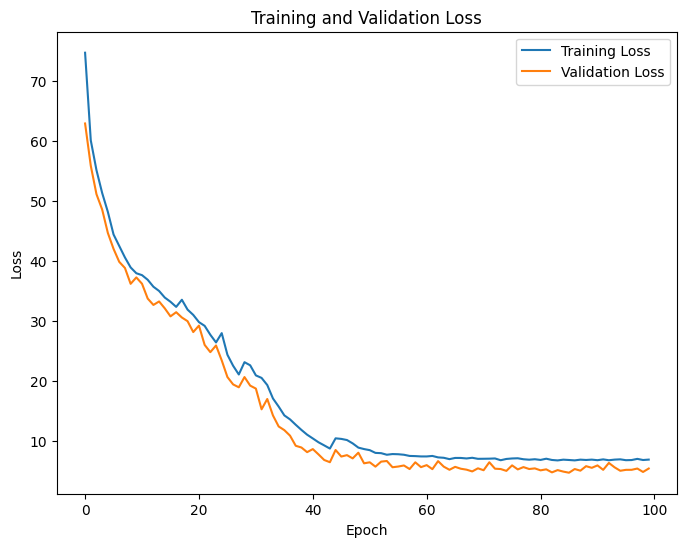

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the result of the `model.fit()`
fig, ax = plt.subplots(figsize=(8, 6))  # Adjusted to use a single plot

# Plotting training and validation loss
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.legend(loc='upper right')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')

# Since we're only plotting loss, we adjust the x-label to be on this ax
ax.set_xlabel('Epoch')  # Adjusting to apply xlabel to the single plot

plt.show()

# 5. Make a Prediction

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

[mpeg1video @ 0x7fd8bc060c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd8bc060c00] Warning MVs not available


In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 1s/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green by h six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay green with a one again'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green by i six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay green with o one again'>]

In [ ]:
import numpy as np

def calculate_wer(reference, hypothesis):
    # Split the sentence into words
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    d = np.zeros((len(ref_words) + 1, len(hyp_words) + 1), dtype=np.uint8)
    for i in range(len(ref_words) + 1):
        for j in range(len(hyp_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i
    for i in range(1, len(ref_words) + 1):
        for j in range(1, len(hyp_words) + 1):
            if ref_words[i-1] == hyp_words[j-1]:
                cost = 0
            else:
                cost = 1
            d[i][j] = min(d[i-1][j] + 1, d[i][j-1] + 1, d[i-1][j-1] + cost)
    return d[len(ref_words)][len(hyp_words)] / float(len(ref_words))

# Load your model weights
model.load_weights('models/checkpoint')

wer_scores = []
accuracies = []

# Assuming 'test' is your test dataset
for sample in test.as_numpy_iterator():
    # Predict
    yhat = model.predict(sample[0])

    # Decode predictions
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=np.ones(yhat.shape[0])*yhat.shape[1], greedy=True)[0][0]

    # Convert to text
    predicted_texts = [tf.strings.reduce_join(num_to_char(c)).numpy().decode('utf-8') for c in decoded]
    real_texts = [tf.strings.reduce_join(num_to_char(c)).numpy().decode('utf-8') for c in sample[1]]

    # Calculate WER and Accuracy for each sample
    for real, pred in zip(real_texts, predicted_texts):
        wer_scores.append(calculate_wer(real, pred))
        accuracies.append(np.mean([1 if c1 == c2 else 0 for c1, c2 in zip(real, pred)]) * 100)

# Calculate average WER and Accuracy
average_wer = np.mean(wer_scores)
average_accuracy = np.mean(accuracies)

print(f"Average WER: {average_wer:.2f}")
print(f"Average Accuracy: {average_accuracy:.2f}%")

1/1 [==============================] - 1s 833ms/step


[mpeg1video @ 0x7fbea00f5680] ac-tex damaged at 22 17
[mpeg1video @ 0x7fbea00f5680] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Average WER: 0.10
Average Accuracy: 94.77%


# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 713ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at n nine again'>]